# 작업 목표

- 기본 작업에 불과하더라도 코드, 작업 이해 부족한 부분 없이 진행하는 것을 이번 프로젝트 목표로 합니다.
- 반복 사용되던 유틸 코드 중, 일부라도 유틸 모듈화하고 프로젝트 코드 내에 활용하려고 합니다. (모듈 활용 이해)


- 통제되지 않은 목차 / 코드 추가되는 것 지양 : 이를 위해 목차나 작업 중 헷갈렸던 부분 정확한 이해가 필요함
- 데드라인이 임박한 상황을 고려한 우선순위 설정 : 코드/학습과정 이해, 클린 코드 > 평가 점수/이미지 복원 수준

In [28]:
# 노트북 상위 폴더 경로 추가
import sys
import os
sys.path.append(os.path.abspath(".."))

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 유틸리티 함수 임포트
from src.utils import get_device, init_logger

- 이번 작업에 모듈화, 폴더 구조 정비를 포함하여 노트북을 하위 폴더로 지정함
- 최소 작업이 목적인 만큼 이후 추가 개선 Notebook 분리또한 고려

In [30]:
logger = init_logger(name="cgan")  # 여기서만 프로젝트 이름을 지정
device = get_device()

logger.info(f"Using device: {device}")

2025-12-06 04:07:21 [INFO] (705987878.py:4) - Using device: mps


Apple MPS GPU detected.


In [31]:
from torchvision import datasets

# 1) 데이터 경로 설정
root = "./data/FashionMNIST"
logger.info(f"Dataset root set to: {root}")

2025-12-06 04:07:23 [INFO] (2239339776.py:5) - Dataset root set to: ./data/FashionMNIST


In [32]:
# from pathlib import Path
# root = Path("./data/FashionMNIST")

Torchvision 내부가 os.path.join() 기반이라 str / Path 둘 다 자동 처리되고, 이번 프로젝트는 간결함이 목적이므로 Pathlib 라이브러리는 사용하지 않음.

In [34]:
from torchvision import transforms

def transform(augment: bool = False):
    """
    학습/검증 모드에 따라 이미지 변환(transform)을 구성하여 반환합니다.

    Parameters
    ----------
    augment : bool, default=False
        True  → 학습용: 데이터 증강 + Normalize
        False → 검증/테스트용: 기본 Normalize만 적용

    Returns
    -------
    torchvision.transforms.Compose
        이미지에 순차적으로 적용될 transform 객체.
    """

    # 공통 변환: Tensor 변환 + [-1, 1] 정규화
    base_transforms = [
        transforms.ToTensor(),                 # PIL → Tensor, [0, 1]
        transforms.Normalize((0.5,), (0.5,))   # [0, 1] → [-1, 1]
    ]

    # 검증/테스트용 리턴: 증강 없이 기본 변환만 적용
    if not augment:
        return transforms.Compose(base_transforms)

    # 학습 변환: 증강 추가
    aug_transforms = [
        transforms.RandomRotation(10),         # ±10도 회전
        transforms.RandomHorizontalFlip(p=0.5) # 50% 확률 좌우 반전
    ]
    # 학습용 리턴: 텐서 변환 + 정규화 + 증강 적용
    return transforms.Compose(aug_transforms + base_transforms)

In [35]:

# 데이터셋 로드
train_dataset = datasets.FashionMNIST(
    root=root,
    train=True,
    download=True,
    transform=transform(augment=True) # 학습용 데이터, 증강 적용
)

test_dataset = datasets.FashionMNIST(
    root=root,
    train=False,
    download=True,
    transform=transform(augment=False) # 검증용 데이터, 증강 미적용
)

logger.info(f"✔ Dataset loaded successfully")
logger.info(f"Train size: {len(train_dataset)}")
logger.info(f"Test size:  {len(test_dataset)}")

2025-12-06 04:07:44 [INFO] (2726678434.py:16) - ✔ Dataset loaded successfully
2025-12-06 04:07:44 [INFO] (2726678434.py:17) - Train size: 60000
2025-12-06 04:07:44 [INFO] (2726678434.py:18) - Test size:  10000


In [36]:
import pandas as pd

channel_list = []
size_list = []
label_list = []

for img, label in train_dataset:
    C, H, W = img.shape
    channel_list.append(C)
    size_list.append((H, W))
    label_list.append(label)

# pandas Series로 변환
channel_series = pd.Series(channel_list)
size_series = pd.Series(size_list)
label_series = pd.Series(label_list)

print("채널 종류:")
print(channel_series.value_counts())

print("\n이미지 크기 종류:")
print(size_series.value_counts())

print("\n라벨 종류:")
print(label_series.value_counts())

print("Pixel min/max:", img.min().item(), img.max().item())  # Should be approx -1~1

채널 종류:
1    60000
Name: count, dtype: int64

이미지 크기 종류:
(28, 28)    60000
Name: count, dtype: int64

라벨 종류:
9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: count, dtype: int64
Pixel min/max: -1.0 1.0


확인 사항
1. 흑백 이미지 (채널 1)
2. 크기 동일 (28 x 28)
3. 0 ~ 9 까지 라벨별로 6000개 씩

In [37]:
import math
import torch
import matplotlib.pyplot as plt

def show_samples(
    dataset,
    n_images: int = 25,
    shuffle: bool = True,
    cols: int = 10,
    show_class_name: bool = True,
):
    """
    Dataset에서 이미지를 grid 형태로 시각화합니다.

    Parameters
    ----------
    dataset : torch.utils.data.Dataset
    n_images : int, default=25
    shuffle : bool, default=True
    cols : int, default=10
    show_class_name : bool, default=True
        True면 class name도 함께 출력 (Dataset의 class_to_idx 기반)
    """

    # -------------------------------
    # class name 매핑 자동 생성
    #    (torchvision Dataset이면 class_to_idx가 있음)
    # -------------------------------
    idx_to_class = None
    if show_class_name and hasattr(dataset, "class_to_idx"):
        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

    # -------------------------------
    # n_images / grid 크기 계산
    # -------------------------------
    cols = max(1, cols)
    n_images = max(1, min(n_images, len(dataset)))
    rows = math.ceil(n_images / cols)

    # -------------------------------
    # 인덱스 샘플 선정
    # -------------------------------
    if shuffle:
        indices = torch.randperm(len(dataset))[:n_images].tolist()
    else:
        indices = list(range(n_images))

    plt.figure(figsize=(cols * 2, rows * 2))

    # -------------------------------
    # 이미지 시각화 루프
    # -------------------------------
    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        # grayscale (1,H,W) → (H,W)
        if img.ndim == 3 and img.shape[0] == 1:
            img_show = img.squeeze(0)
        else:
            img_show = img

        # title 구성
        if idx_to_class:
            title = f"{label}: {idx_to_class[label]}"
        else:
            title = str(label)

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img_show, cmap="gray")
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

- 이후 학습/검증에도 시각화가 필수적이므로 함수로 정의
- 클래스 라벨은 int로 되어있으므로, 데이터셋 안에 있는 클래스명과 맵핑이 시각화에 유리함 (함수 내 포함)

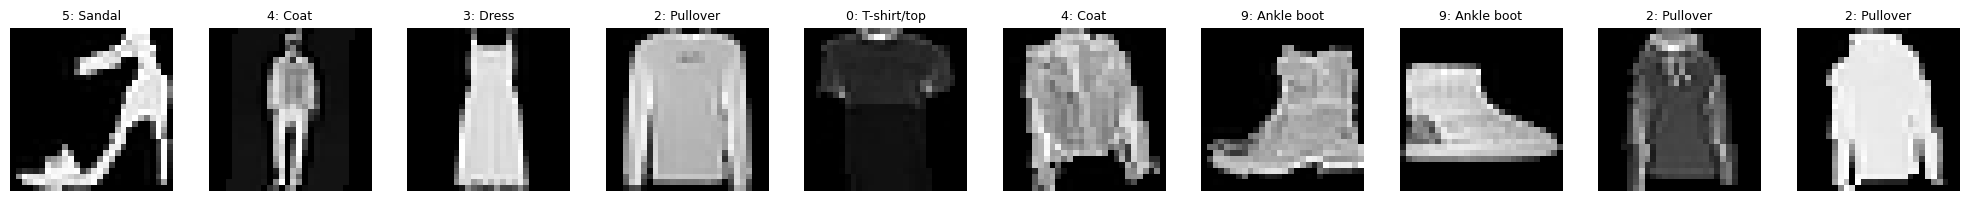

In [38]:
show_samples(train_dataset, n_images=10)

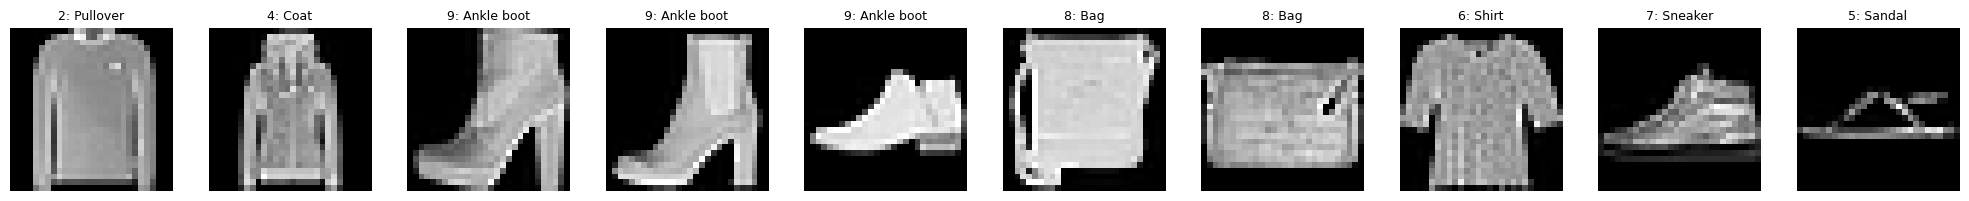

In [39]:
show_samples(test_dataset, n_images=10)

# 데이터 로더 정의/적용

In [40]:
from torch.utils.data import DataLoader

# ---------------------------------------------------
# DataLoader 정의
#    - batch_size: 한 번에 모델에 넣을 샘플 수
#    - shuffle   : 학습용만 셔플
# ---------------------------------------------------
batch_size = 128  # 필요하면 나중에만 수정

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,      # 학습용: 매 epoch마다 데이터 섞기
    num_workers=2,     # 데이터 로딩용 서브 프로세스 수 (필요에 따라 0~2 정도 조정)
    drop_last=True,    # 마지막 배치가 batch_size보다 작으면 버림 (GAN에서 종종 사용)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,     # 평가용: 순서 유지
    num_workers=2,
    drop_last=False,   # 평가에서는 마지막 배치도 사용
)

logger.info(f"✔ DataLoader 준비 완료")
logger.info(f"Dataloader batch size: {batch_size}")
logger.info(f"Train loader batches: {len(train_loader)}")
logger.info(f"Test  loader batches: {len(test_loader)}")

2025-12-06 04:08:04 [INFO] (3945817841.py:26) - ✔ DataLoader 준비 완료
2025-12-06 04:08:04 [INFO] (3945817841.py:27) - Dataloader batch size: 128
2025-12-06 04:08:04 [INFO] (3945817841.py:28) - Train loader batches: 468
2025-12-06 04:08:04 [INFO] (3945817841.py:29) - Test  loader batches: 79


# 모델 정의

In [41]:
import torch
import torch.nn as nn

image_size  = 28       # FashionMNIST
num_classes = 10
latent_dim  = 100

# ---------------------------------------------------
# 5) cGAN 모델 정의
#    - Generator: 노이즈 + 레이블 → 이미지 생성
#    - Discriminator: 이미지 + 레이블 → 진짜/가짜 판별
# ---------------------------------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim: int, num_classes: int, img_size: int):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = img_size // 4  # 7 (28/4)

        # [Block A] 선형 레이어로 7x7x128 feature map 기초 생성
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes,
                      128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True),
        )

        # [Block B, C] 업샘플링으로 7→14→28 이미지 생성
        self.conv_blocks = nn.Sequential(
            # 7x7, 128채널 feature 정규화
            nn.BatchNorm2d(128),
            # 7 → 14
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            # 14 → 28
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),  # 출력 범위 [-1, 1]
        )

    def forward(self, noise: torch.Tensor, labels: torch.Tensor):
        # noise: (B, latent_dim)
        # labels: (B,) int → (B, num_classes) embedding
        label_vec = self.label_emb(labels)
        x = torch.cat([noise, label_vec], dim=1)  # (B, latent+num_classes)

        out = self.l1(x)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)  # (B, 1, 28, 28)
        return img


class Discriminator(nn.Module):
    def __init__(self, num_classes: int, img_size: int):
        super().__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # (이미지 1채널 + 레이블 1채널) → 2채널 입력
            nn.Conv2d(2, 64, kernel_size=3, stride=2, padding=1),  # 28→14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 14→7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * (img_size // 4) * (img_size // 4), 1),  # 128*7*7
            nn.Sigmoid(),  # 0~1 (진짜일 확률)
        )

    def forward(self, img: torch.Tensor, labels: torch.Tensor):
        b = img.size(0)
        # 레이블을 (B, 1, H, W)로 확장해서 이미지와 채널 방향으로 concat
        label_map = self.label_emb(labels)           # (B, 1)
        label_map = label_map.view(b, 1, 1, 1)
        label_map = label_map.expand(b, 1,
                                     self.img_size, self.img_size)
        x = torch.cat([img, label_map], dim=1)       # (B, 2, H, W)
        validity = self.model(x)                     # (B, 1)
        return validity

# 하이퍼 파라미터 설정/모델 초기화/손실함수/옵티마이저 설정

In [42]:
# 하이퍼파라미터 설정
latent_dim  = 100
image_size  = 28
num_classes = 10
batch_size  = 128
num_epochs  = 15                       # 이후 에폭 늘려서 작업 필요

lr = 0.0002
betas = (0.5, 0.999)

In [43]:
# 모델 생성
G = Generator(latent_dim, num_classes, image_size).to(device)
D = Discriminator(num_classes, image_size).to(device)

# 손실함수
criterion = nn.BCELoss()

# 옵티마이저
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)

# 학습

2025-12-06 04:21:24 [INFO] (3831450062.py:91) - ===== Start Training cGAN =====
2025-12-06 04:21:54 [INFO] (3831450062.py:156) - [Epoch 001/015] D_loss: 0.5272 | G_loss: 1.0930
2025-12-06 04:22:23 [INFO] (3831450062.py:156) - [Epoch 002/015] D_loss: 0.5179 | G_loss: 1.1202
2025-12-06 04:22:55 [INFO] (3831450062.py:156) - [Epoch 003/015] D_loss: 0.5068 | G_loss: 1.1491
2025-12-06 04:23:27 [INFO] (3831450062.py:156) - [Epoch 004/015] D_loss: 0.4968 | G_loss: 1.1743
2025-12-06 04:24:00 [INFO] (3831450062.py:156) - [Epoch 005/015] D_loss: 0.4871 | G_loss: 1.2045
2025-12-06 04:24:00 [INFO] (3831450062.py:165) - Epoch 5: generating sample images...


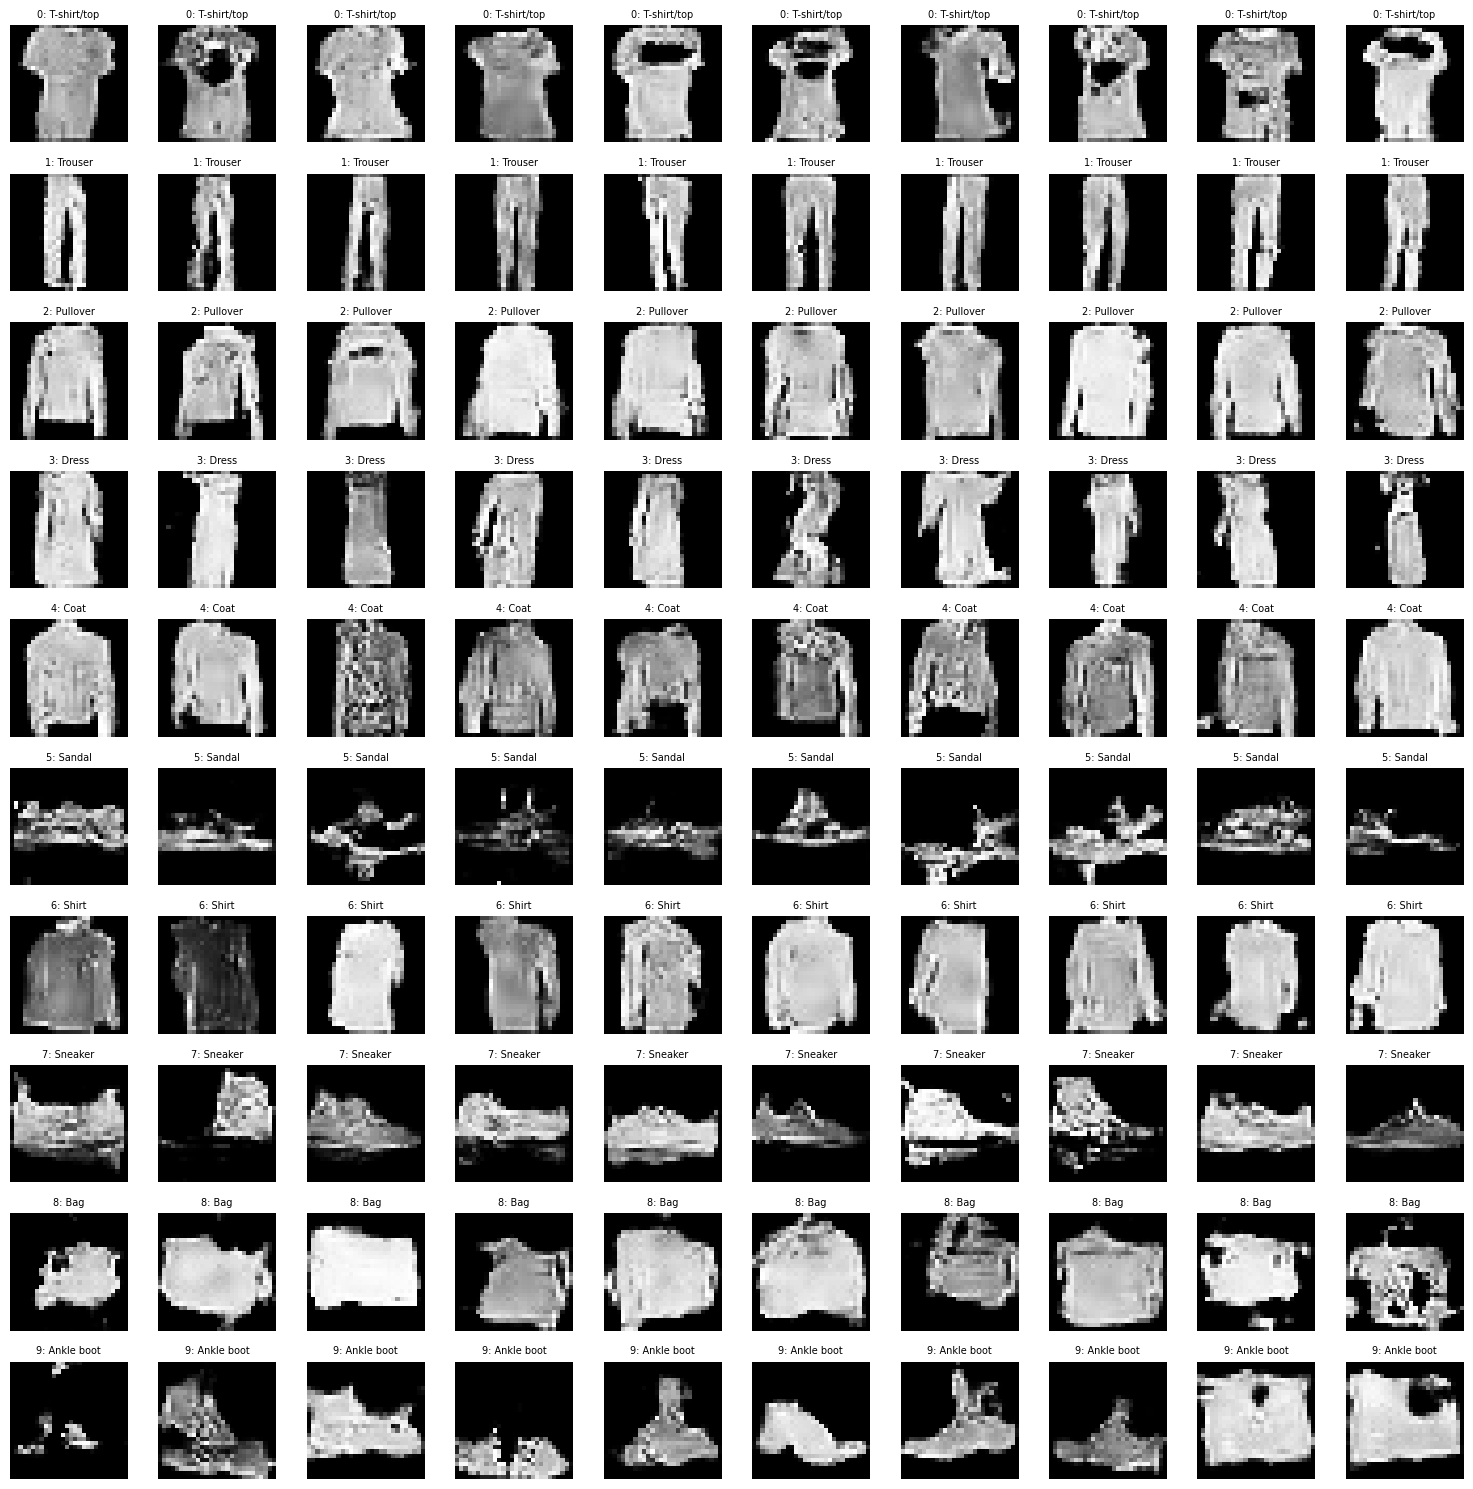

2025-12-06 04:24:37 [INFO] (3831450062.py:156) - [Epoch 006/015] D_loss: 0.4757 | G_loss: 1.2338
2025-12-06 04:25:08 [INFO] (3831450062.py:156) - [Epoch 007/015] D_loss: 0.4647 | G_loss: 1.2685
2025-12-06 04:25:55 [INFO] (3831450062.py:156) - [Epoch 008/015] D_loss: 0.4628 | G_loss: 1.2847
2025-12-06 04:26:25 [INFO] (3831450062.py:156) - [Epoch 009/015] D_loss: 0.4545 | G_loss: 1.3222
2025-12-06 04:26:55 [INFO] (3831450062.py:156) - [Epoch 010/015] D_loss: 0.4399 | G_loss: 1.3450
2025-12-06 04:26:55 [INFO] (3831450062.py:165) - Epoch 10: generating sample images...


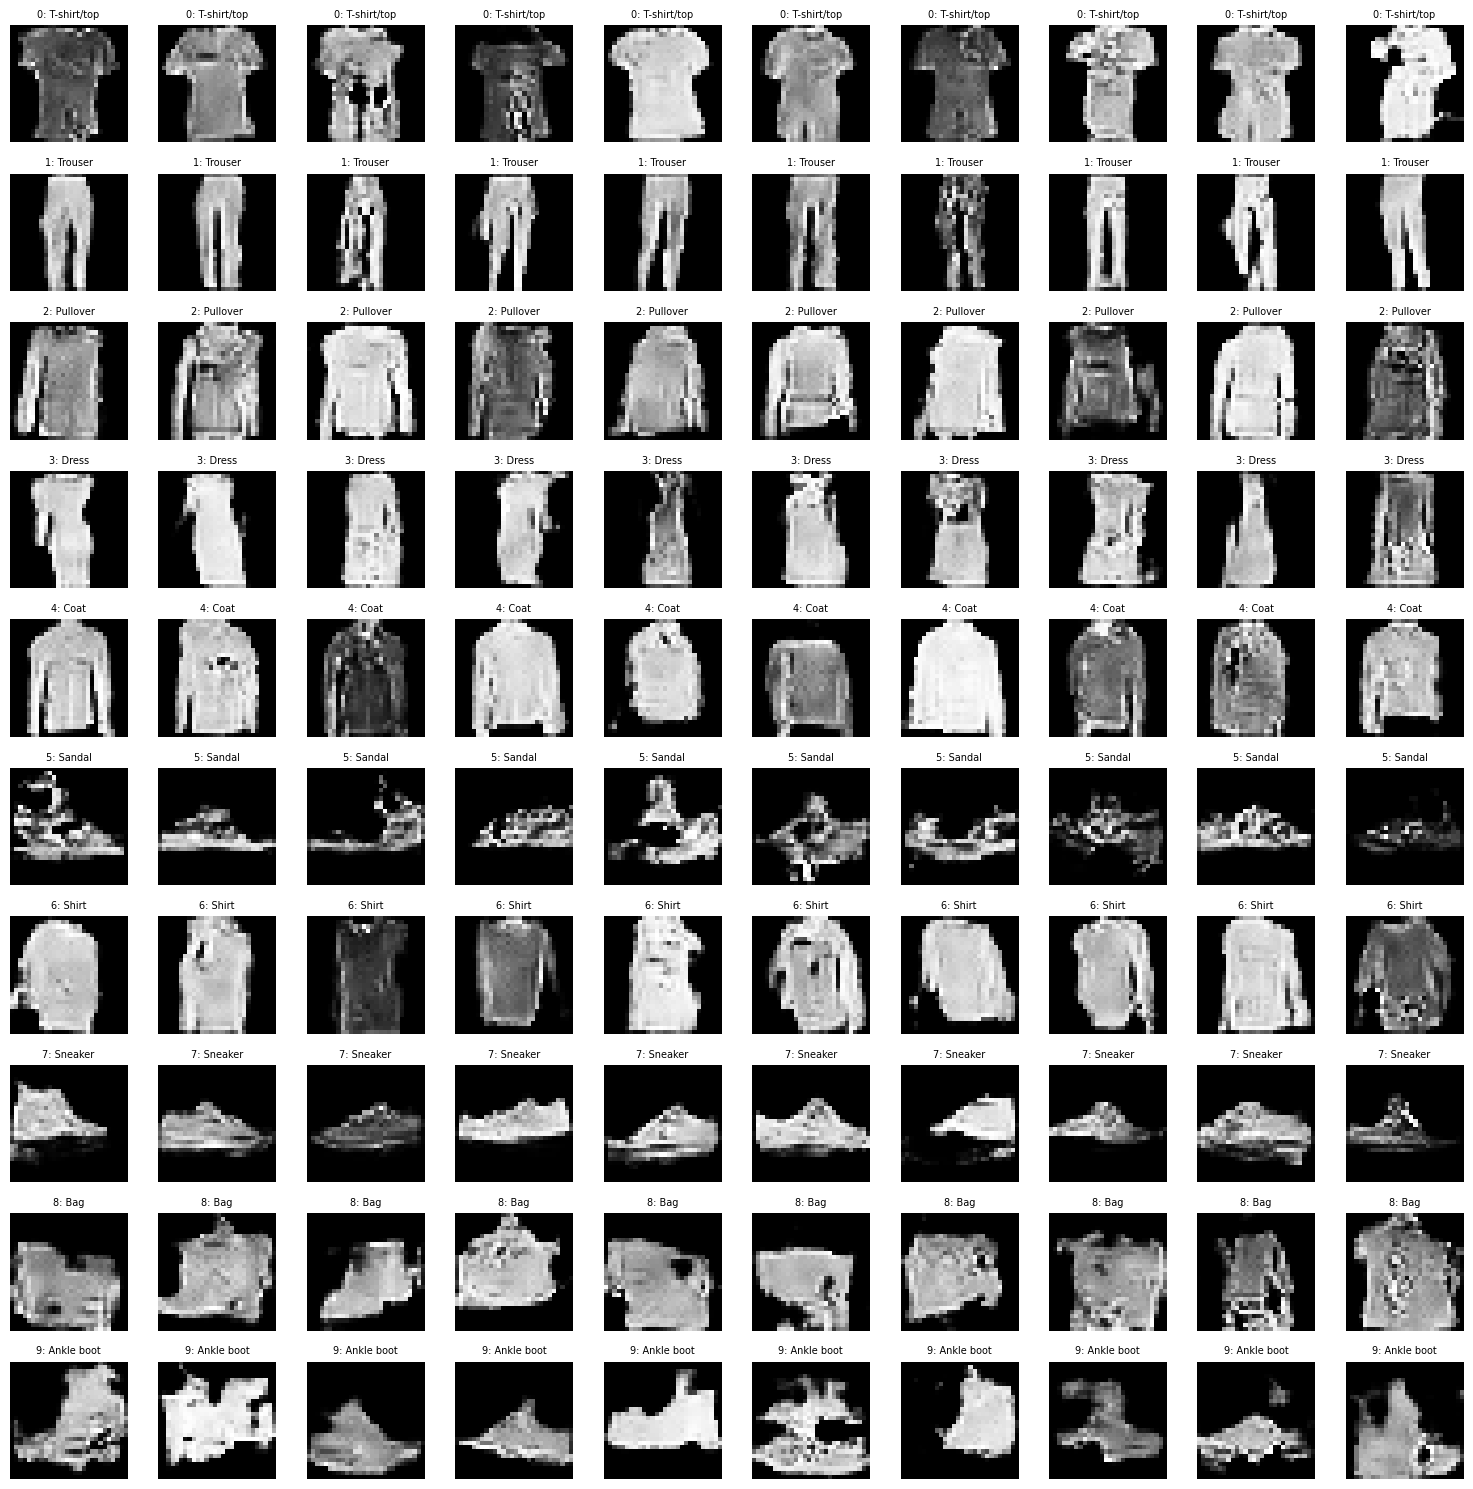

2025-12-06 04:27:29 [INFO] (3831450062.py:156) - [Epoch 011/015] D_loss: 0.4394 | G_loss: 1.3723
2025-12-06 04:28:03 [INFO] (3831450062.py:156) - [Epoch 012/015] D_loss: 0.4337 | G_loss: 1.3894
2025-12-06 04:28:34 [INFO] (3831450062.py:156) - [Epoch 013/015] D_loss: 0.4321 | G_loss: 1.4103
2025-12-06 04:29:09 [INFO] (3831450062.py:156) - [Epoch 014/015] D_loss: 0.4218 | G_loss: 1.4401
2025-12-06 04:29:42 [INFO] (3831450062.py:156) - [Epoch 015/015] D_loss: 0.4140 | G_loss: 1.4625
2025-12-06 04:29:42 [INFO] (3831450062.py:165) - Epoch 15: generating sample images...


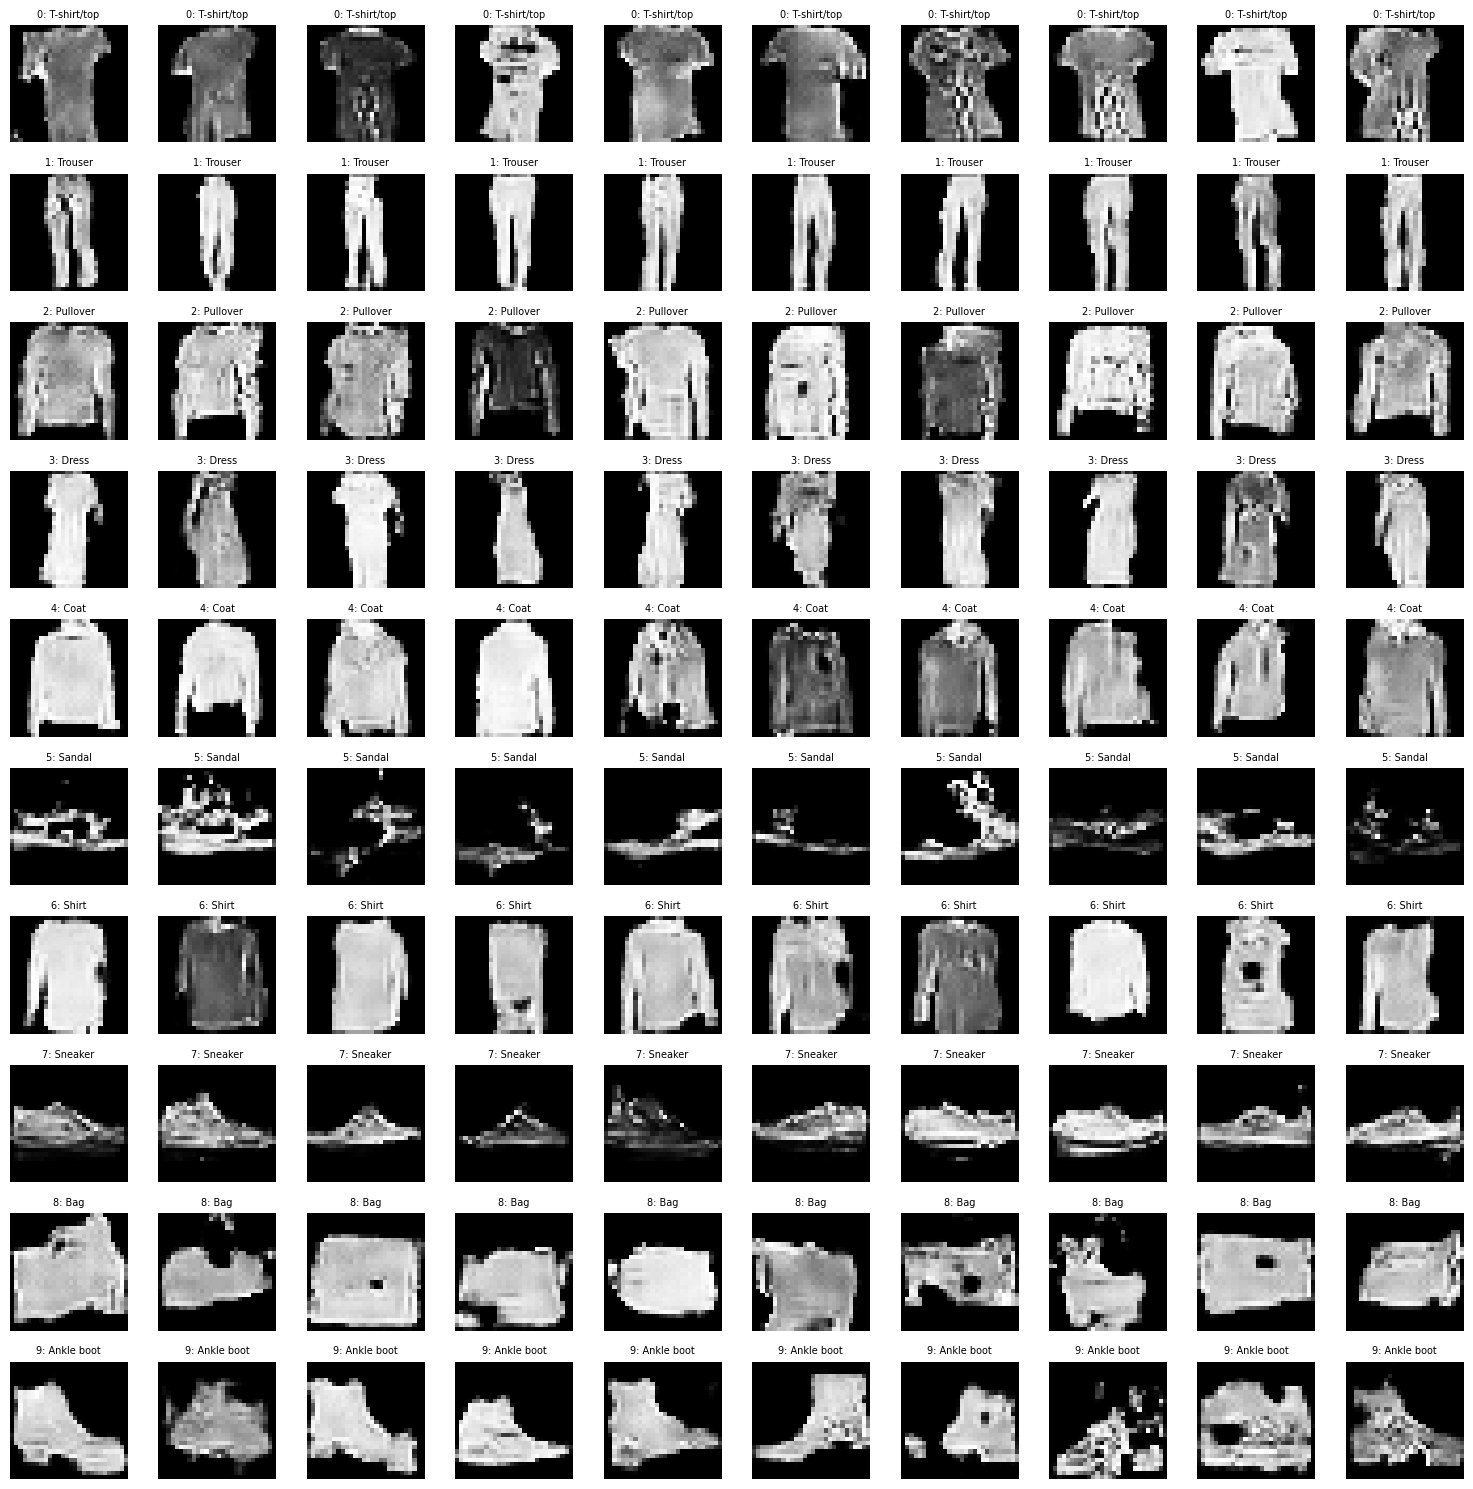

2025-12-06 04:29:43 [INFO] (3831450062.py:168) - ===== Training Finished =====


In [45]:
import torch
import matplotlib.pyplot as plt

# 학습 설정
batch_size  = train_loader.batch_size  # 이미 정의된 값 사용
latent_dim  = latent_dim               # 위에서 정의한 하이퍼파라미터
num_classes = num_classes              # 위에서 정의한 하이퍼파라미터

# 고정된 노이즈/레이블 (매 5 epoch마다 같은 조건으로 샘플 시각화)
n_vis_rows = 5
n_vis_cols = 5
n_vis      = n_vis_rows * n_vis_cols

fixed_noise  = torch.randn(n_vis, latent_dim, device=device)
fixed_labels = torch.arange(0, n_vis, device=device) % num_classes  # 0~9 반복



def show_generated_by_class(
    generator,
    latent_dim,
    num_classes,
    device,
    dataset=None,          # dataset이 있으면 class_name 매핑 자동 생성
    n_per_class: int = 10, # 클래스당 출력 개수
    show_class_name: bool = True,
):
    """
    cGAN Generator로부터 생성 이미지 출력.
    각 클래스를 한 행(row)로 하여 n_per_class개씩 출력.

    - dataset.class_to_idx 기반으로 클래스명 자동 매핑
    - MNIST처럼 0~9 클래스 구조에서 유용
    """

    generator.eval()

    # -----------------------------------
    # idx_to_class 자동 생성
    # -----------------------------------
    idx_to_class = None
    if show_class_name and dataset is not None and hasattr(dataset, "class_to_idx"):
        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

    # -----------------------------------
    # 노이즈 + 라벨 생성
    # -----------------------------------
    total = num_classes * n_per_class

    noise = torch.randn(total, latent_dim, device=device)
    labels = torch.arange(0, num_classes, device=device).repeat_interleave(n_per_class)

    with torch.no_grad():
        imgs = generator(noise, labels).cpu()  # (100,1,28,28)
    generator.train()

    # [-1,1] → [0,1]
    imgs = (imgs + 1) / 2.0

    # -----------------------------------
    # grid(행=클래스, 열=n_per_class)
    # -----------------------------------
    rows = num_classes
    cols = n_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))

    idx = 0
    for cls in range(num_classes):
        for c in range(cols):
            ax = axes[cls, c]
            ax.imshow(imgs[idx, 0], cmap="gray")

            # -------------------------------
            # title 구성 (너가 요구한 패턴 그대로)
            # -------------------------------
            if idx_to_class:
                name = idx_to_class[cls]  # class name
                title = f"{cls}: {name}"
            else:
                title = str(cls)

            ax.set_title(title, fontsize=7)
            ax.axis("off")
            idx += 1

    plt.tight_layout()
    plt.show()



logger.info("===== Start Training cGAN =====")

for epoch in range(1, num_epochs + 1):
    G.train()
    D.train()

    epoch_g_loss = 0.0
    epoch_d_loss = 0.0

    for real_imgs, real_labels in train_loader:
        real_imgs   = real_imgs.to(device)   # (B,1,28,28)
        real_labels = real_labels.to(device) # (B,)

        curr_batch_size = real_imgs.size(0)

        # 진짜/가짜 타깃 레이블 (BCELoss용)
        valid = torch.ones(curr_batch_size, 1, device=device)
        fake  = torch.zeros(curr_batch_size, 1, device=device)

        # -------------------------
        # 1) Generator 업데이트
        # -------------------------
        optimizer_G.zero_grad()

        # 노이즈 + 레이블 샘플링
        z       = torch.randn(curr_batch_size, latent_dim, device=device)
        gen_lbl = torch.randint(0, num_classes, (curr_batch_size,), device=device)

        gen_imgs   = G(z, gen_lbl)
        validity_g = D(gen_imgs, gen_lbl)

        g_loss = criterion(validity_g, valid)  # Generator는 "가짜를 진짜처럼" 속이고 싶음
        g_loss.backward()
        optimizer_G.step()

        # -------------------------
        # 2) Discriminator 업데이트
        # -------------------------
        optimizer_D.zero_grad()

        # (a) 진짜 이미지에 대한 손실
        validity_real = D(real_imgs, real_labels)
        d_real_loss   = criterion(validity_real, valid)

        # (b) 가짜 이미지에 대한 손실 (detach로 G gradient 차단)
        z       = torch.randn(curr_batch_size, latent_dim, device=device)
        gen_lbl = torch.randint(0, num_classes, (curr_batch_size,), device=device)
        gen_imgs = G(z, gen_lbl).detach()

        validity_fake = D(gen_imgs, gen_lbl)
        d_fake_loss   = criterion(validity_fake, fake)

        # 진짜/가짜 손실 평균
        d_loss = 0.5 * (d_real_loss + d_fake_loss)
        d_loss.backward()
        optimizer_D.step()

        epoch_g_loss += g_loss.item() * curr_batch_size
        epoch_d_loss += d_loss.item() * curr_batch_size

    # 배치 수 기준 평균 loss
    n_train = len(train_dataset)
    avg_g = epoch_g_loss / n_train
    avg_d = epoch_d_loss / n_train

    logger.info(
        f"[Epoch {epoch:03d}/{num_epochs:03d}] "
        f"D_loss: {avg_d:.4f} | G_loss: {avg_g:.4f}"
    )

    # ---------------------------------------------------
    # 5 epoch마다 생성 이미지 시각화
    # ---------------------------------------------------
    if epoch % 5 == 0:
        logger.info(f"Epoch {epoch}: generating sample images...")
        show_generated_by_class(G, latent_dim, num_classes, device, dataset=train_dataset, n_per_class=10, show_class_name=True)

logger.info("===== Training Finished =====")

# 평가

In [47]:
def evaluate_gan(
    D,
    G,
    data_loader,
    device,
    latent_dim: int,
    num_classes: int,
    n_batches: int = 100,
):
    """
    Discriminator 출력을 이용한 간단 정량 평가:
    - real_score: D(real)의 평균
    - fake_score: D(fake)의 평균
    - fooling_rate: D(fake) > 0.5 비율 (Generator가 D를 속이는 비율)
    """
    D.eval()
    G.eval()

    real_scores = []
    fake_scores = []
    fooling_rates = []

    with torch.no_grad():
        for i, (real_imgs, real_labels) in enumerate(data_loader):
            if i >= n_batches:
                break

            real_imgs = real_imgs.to(device)
            real_labels = real_labels.to(device)
            batch_size = real_imgs.size(0)

            # ----- Real -----
            validity_real = D(real_imgs, real_labels)   # (B,1)
            real_scores.append(validity_real.mean().item())

            # ----- Fake -----
            z       = torch.randn(batch_size, latent_dim, device=device)
            gen_lbl = torch.randint(0, num_classes, (batch_size,), device=device)
            gen_imgs = G(z, gen_lbl)

            validity_fake = D(gen_imgs, gen_lbl)        # (B,1)
            fake_scores.append(validity_fake.mean().item())

            # D(fake) > 0.5 → G가 D를 속였다고 간주
            fooling = (validity_fake > 0.5).float().mean().item()
            fooling_rates.append(fooling)

    D.train()
    G.train()

    metrics = {
        "real_score": sum(real_scores) / len(real_scores),
        "fake_score": sum(fake_scores) / len(fake_scores),
        "fooling_rate": sum(fooling_rates) / len(fooling_rates),
    }
    return metrics

In [48]:
logger.info("===== Evaluating cGAN (simple quantitative metrics) =====")
metrics = evaluate_gan(
    D=D,
    G=G,
    data_loader=train_loader,
    device=device,
    latent_dim=latent_dim,
    num_classes=num_classes,
    n_batches=100,  # 너무 크면 줄이고, 작으면 늘려도 됨
)

logger.info(
    "Eval result - D(real) mean: {:.3f}, D(fake) mean: {:.3f}, G fooling rate: {:.3f}".format(
        metrics["real_score"],
        metrics["fake_score"],
        metrics["fooling_rate"],
    )
)

print(metrics)

2025-12-06 04:30:51 [INFO] (2186246269.py:1) - ===== Evaluating cGAN (simple quantitative metrics) =====
2025-12-06 04:30:56 [INFO] (2186246269.py:12) - Eval result - D(real) mean: 0.689, D(fake) mean: 0.382, G fooling rate: 0.312


{'real_score': 0.6894340312480927, 'fake_score': 0.38199920296669004, 'fooling_rate': 0.311953125}


# 회고

1. 환경정리 후, DL 전용 환경을 하나 생성 완료함, 기본 파이썬 설정 또한 nano ash_profile, zsh txt 가 옛날에 수정되어 있던 걸 이번에 찾아서 brew 전역 파이썬이 잡히도록 수정
    1-a. 완벽하게 정리된 것 같았으나 vscode 재시작 후, '모두 실행' 클릭 시 Notebook controller is DISPOSED 오류를 얻었다   
    (각 셀 실행은 되고, 구글링에 비슷한 케이스들이 보여서 수정은 가능할듯 하지만(지금은 보류)
2. get_device, logger는 src/utils에 넣어두고 __init__설정까지 시도해봄. 이후, 프로젝트의 개인 브랜치 폴더도 지금보다 구조화된 형태로 작업할 것 기대.
3. 학습데이터 분류, 트랜스폼 정의/적용, 모델정의, criterion, 옵티마이저의 정의 순서 / 모델 내부 레이어 구조와 학습루프에서 각 기능들의 작동 순서 같은 것이 gpt의 시도 따라 중구난방이 되던것을 이번기회에 프레임워크를 정돈함.
4. 클린 코딩 시도(gpt가 작업하더라도, 작은 부분만 진행하고 해당 부분만 리펙토링하는 방식으로라도)를 진행하니 확실히 코드통제가 벗어나지 않아서 좋았다. 다만 이것도 프로젝트를 엄청 단순화 했음에도 시간이 오래걸려 중후반부는 라인바이라인 다 뜯지 못했음. (그러나 필수적이라고 느낌: 직접 다 짜진 않아도 모르는/이해 못 한 라인이 있는 건 말이 안된다고 생각함.)
5. 전처리 로컬작업 -> 학습 코랩작업 -> 코랩에서 학습된 모델파일 로컬에서 평가/시각화 가 목표였으나 시간 관계로 보류
    5.1 밀린 TODO 1 : 코랩에서 현재 폴더구조의 'src/util .py' import
    5.2 밀린 TODO 2 : 학습 과정 체크포인트 + 터졌을 때 중간 모델 저장
6. 로스 줄어드는 것 확실히 확인 + 에폭 더 돌렸어야함...
7. 이번 cGAN 모델의 작동방식/레이어 구조는 이해했으나, 직접 짜는 것은 미뤄짐